# **Visual Information Processing and Management**
---
---

Università degli Studi Milano Bicocca \
CdLM Informatica — A.A 2025/2026

---
---

### **Componenti del gruppo:**
— Oleksandra Golub (856706) \
— Andrea Spagnolo (879254)




## **Librerie**




In [19]:
import random
import os, time, copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageOps
from dataclasses import dataclass
from typing import Optional, Dict, Tuple, List
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.amp import GradScaler, autocast
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torchvision.models.resnet import ResNet, conv3x3

## **Configurazione + Device**

In [20]:
@dataclass
class Config:
    # paths
    data_dir = "/kaggle/input/datasets/andreaspagnolo/visual-exam-dataset-2/visual_dataset"
    #data_dir: str = "/kaggle/input/visual-exam-dataset/visual_dataset"
    test_dir = "/kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/test"
    #test_dir: str = "/kaggle/input/visual-exam-dataset/visual_dataset/test"

    # training
    batch_size: int = 64
    epochs: int = 50
    lr: float = 3e-4
    weight_decay: float = 0.0
    num_workers: int = 4

    # early stopping
    patience: int = 3
    min_delta: float = 1e-3
    monitor: str = "val_loss"  # "val_loss" or "val_f1"
    best_path: str = "best_baseline0_db2.pth"

    # loss / regularization
    label_smoothing: float = 0.0

    # mixup
    mixup_alpha: float = 0.0
    mixup_prob: float = 0.0

    # model
    se_reduction: int = 16

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_device() -> torch.device:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    return device


def sanity_check_paths(cfg: Config):
    if not os.path.exists(cfg.data_dir):
        raise FileNotFoundError(f"Train/Val root not found: {cfg.data_dir}")
    print(f"Dataset root: {cfg.data_dir}")
    print(f"Folders found: {os.listdir(cfg.data_dir)}")

    if not os.path.exists(cfg.test_dir):
        print(f"WARNING: Test dir not found: {cfg.test_dir}")
    else:
        print(f"Test dir: {cfg.test_dir}")

## **Preprocessing + Data Augmentation**

In [21]:
class GrayWorldWB:
    def __call__(self, img: Image.Image) -> Image.Image:
        arr = np.asarray(img).astype(np.float32)
        mean = arr.mean(axis=(0, 1), keepdims=True)
        arr = arr / (mean + 1e-6)
        arr = arr / (arr.max() + 1e-6)
        return Image.fromarray((arr * 255).astype(np.uint8))


class AutoContrast:
    def __call__(self, img: Image.Image) -> Image.Image:
        return ImageOps.autocontrast(img, cutoff=1)


def build_transforms() -> Dict[str, transforms.Compose]:
    train_tf = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ])

    val_tf = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ])

    return {"train": train_tf, "val": val_tf}


def build_test_transforms() -> transforms.Compose:
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),
    ])

## **Dataset + DataLoader**

In [22]:
def build_datasets(cfg: Config, tfs: Dict[str, transforms.Compose]):
    train_ds = datasets.ImageFolder(os.path.join(cfg.data_dir, "train"), tfs["train"])
    val_ds   = datasets.ImageFolder(os.path.join(cfg.data_dir, "valid"), tfs["val"])

    class_names = train_ds.classes
    num_classes = len(class_names)

    print(f"Number of classes: {num_classes}")
    print(f"Training samples: {len(train_ds)}")
    print(f"Validation samples: {len(val_ds)}")

    return {"train": train_ds, "val": val_ds}, class_names, num_classes


def build_dataloaders(cfg: Config, device: torch.device, dsets):
    pin_memory = (device.type == "cuda")
    persistent = (cfg.num_workers > 0)

    dl_kwargs = dict(
        batch_size=cfg.batch_size,
        num_workers=cfg.num_workers,
        pin_memory=pin_memory,
        persistent_workers=persistent,
    )
    if persistent:
        dl_kwargs["prefetch_factor"] = 2

    dls = {
        "train": DataLoader(dsets["train"], shuffle=True,  **dl_kwargs),
        "val":   DataLoader(dsets["val"],   shuffle=False, **dl_kwargs),
    }
    sizes = {"train": len(dsets["train"]), "val": len(dsets["val"])}
    return dls, sizes


## **Modello Resnet18 senza pesi**

In [23]:
def build_resnet18(num_classes: int, device: torch.device) -> nn.Module:
    # ResNet18 standard torchvision, niente pesi pretrained
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)


def build_amp_scaler(device: torch.device) -> GradScaler:
    return GradScaler(enabled=(device.type == "cuda"))

## **Mixup Utils**

In [24]:
def mixup_data(x, y, alpha=0.2):
    if alpha <= 0:
        return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    x_mix = lam * x + (1 - lam) * x[idx]
    return x_mix, y, y[idx], lam


def one_hot(labels, num_classes, device):
    return F.one_hot(labels, num_classes=num_classes).float().to(device)


def soft_cross_entropy(logits, soft_targets):
    log_probs = F.log_softmax(logits, dim=1)
    return -(soft_targets * log_probs).sum(dim=1).mean()

## **Training (early stop + metriche)**

In [25]:
def train_model(
    model: nn.Module,
    dataloaders: Dict[str, DataLoader],
    dataset_sizes: Dict[str, int],
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    scheduler,
    device: torch.device,
    cfg: Config,
    scaler: Optional[GradScaler],
    num_classes: int
) -> Tuple[nn.Module, Dict[str, List[float]]]:

    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch = -1

    if cfg.monitor not in ("val_loss", "val_f1"):
        raise ValueError("monitor must be 'val_loss' or 'val_f1'")

    if cfg.monitor == "val_loss":
        best_metric = float("inf")
        mode = "min"
    else:
        best_metric = -float("inf")
        mode = "max"

    epochs_no_improve = 0

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc":  [], "val_acc":  [],
        "train_f1":   [], "val_f1":   [],
    }

    for epoch in range(cfg.epochs):
        print(f"Epoch {epoch}/{cfg.epochs - 1}")
        print("-" * 10)

        epoch_stats = {}

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()

            running_loss = 0.0
            running_corrects = 0.0
            seen = 0

            all_preds = []
            all_targets = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                optimizer.zero_grad(set_to_none=True)

                with torch.set_grad_enabled(phase == "train"):

                    # MixUp SOLO in train
                    use_mixup = (phase == "train" and np.random.rand() < cfg.mixup_prob)
                    if use_mixup:
                        inputs_mix, y_a, y_b, lam = mixup_data(inputs, labels, alpha=cfg.mixup_alpha)
                        soft_targets = lam * one_hot(y_a, num_classes, device) + (1 - lam) * one_hot(y_b, num_classes, device)

                        with autocast(device_type="cuda", enabled=(device.type == "cuda")):
                            outputs = model(inputs_mix)
                            loss = soft_cross_entropy(outputs, soft_targets)

                        _, preds = torch.max(outputs, 1)

                        # accuracy pesata (logging)
                        correct_a = (preds == y_a).float().sum().item()
                        correct_b = (preds == y_b).float().sum().item()
                        batch_corrects = lam * correct_a + (1 - lam) * correct_b

                        hard_targets_for_f1 = y_a  # indicativo
                    else:
                        with autocast(device_type="cuda", enabled=(device.type == "cuda")):
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)

                        _, preds = torch.max(outputs, 1)
                        batch_corrects = (preds == labels).float().sum().item()
                        hard_targets_for_f1 = labels

                    if phase == "train":
                        if scaler is not None and device.type == "cuda":
                            scaler.scale(loss).backward()
                            scaler.step(optimizer)
                            scaler.update()
                        else:
                            loss.backward()
                            optimizer.step()

                bs = inputs.size(0)
                running_loss += loss.item() * bs
                running_corrects += batch_corrects
                seen += bs

                all_preds.append(preds.detach().cpu().numpy())
                all_targets.append(hard_targets_for_f1.detach().cpu().numpy())

            if phase == "train" and scheduler is not None:
                scheduler.step()

            denom = max(1, seen)
            epoch_loss = running_loss / denom
            epoch_acc = running_corrects / denom

            all_preds = np.concatenate(all_preds) if all_preds else np.array([], dtype=np.int64)
            all_targets = np.concatenate(all_targets) if all_targets else np.array([], dtype=np.int64)
            epoch_f1 = f1_score(all_targets, all_preds, average="macro", zero_division=0) if all_targets.size else 0.0

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1(macro): {epoch_f1:.4f}")

            epoch_stats[f"{phase}_loss"] = epoch_loss
            epoch_stats[f"{phase}_acc"] = epoch_acc
            epoch_stats[f"{phase}_f1"] = epoch_f1

        # history
        for k in history.keys():
            history[k].append(epoch_stats[k])

        # early stopping
        current = epoch_stats[cfg.monitor]

        improved = (best_metric - current) > cfg.min_delta if mode == "min" else (current - best_metric) > cfg.min_delta

        if improved:
            best_metric = current
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), cfg.best_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= cfg.patience:
            print(f"Early stopping at epoch {epoch} (best {cfg.monitor} at epoch {best_epoch}: {best_metric:.6f})")
            break

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed/60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best {cfg.monitor}: {best_metric:.6f} at epoch {best_epoch}")

    model.load_state_dict(best_model_wts)
    return model, history

## **Plot delle curve**

In [26]:
def plot_history(history: Dict[str, List[float]]):
    epochs_range = range(len(history["train_loss"]))
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, history["train_loss"], label="Train Loss")
    plt.plot(epochs_range, history["val_loss"], label="Val Loss")
    plt.title("Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.legend(); plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, history["train_acc"], label="Train Acc")
    plt.plot(epochs_range, history["val_acc"], label="Val Acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.legend(); plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, history["train_f1"], label="Train Macro-F1")
    plt.plot(epochs_range, history["val_f1"], label="Val Macro-F1")
    plt.title("Macro-F1")
    plt.xlabel("Epoch"); plt.ylabel("Macro-F1")
    plt.legend(); plt.grid(True)

    plt.tight_layout()
    plt.show()

## **Evaluation su test + Matrice di confusione**

In [27]:
def build_test_loader(cfg: Config, device: torch.device):
    if not os.path.exists(cfg.test_dir):
        raise FileNotFoundError(f"Test directory not found at {cfg.test_dir}")

    test_tf = build_test_transforms()
    test_ds = datasets.ImageFolder(cfg.test_dir, transform=test_tf)

    test_loader = DataLoader(
        test_ds,
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=(device.type == "cuda"),
    )

    print(f"Test samples found: {len(test_ds)}")
    print(f"Classes found: {len(test_ds.classes)}")
    return test_ds, test_loader


@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, device: torch.device) -> Tuple[float, float, np.ndarray, np.ndarray]:
    model.eval()
    model.to(device)

    all_preds = []
    all_targets = []

    for inputs, labels in loader:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.append(preds.cpu().numpy())
        all_targets.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    acc = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average="macro", zero_division=0)
    return acc, f1, all_targets, all_preds


def plot_confusion_matrix(cm: np.ndarray, title: str = "Confusion Matrix (normalized)"):
    cm_norm = cm.astype(np.float32) / np.maximum(cm.sum(axis=1, keepdims=True), 1)

    plt.figure(figsize=(18, 16))
    sns.heatmap(cm_norm, cmap="viridis", xticklabels=False, yticklabels=False)
    plt.title(title)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()


def print_top_confusions(cm: np.ndarray, class_names: List[str], top_k: int = 100):
    cm_no_diag = cm.copy()
    np.fill_diagonal(cm_no_diag, 0)

    pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm_no_diag[i, j] > 0:
                pairs.append((i, j, cm_no_diag[i, j]))

    pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)

    print(f"\nTop {top_k} coppie più confuse:\n")
    for i, j, value in pairs_sorted[:top_k]:
        print(f"{class_names[i]} → {class_names[j]}  | {value} errori")

## **Main**

In [28]:
cfg = Config()
set_seed(42) 
device = get_device()
sanity_check_paths(cfg)

Using device: cuda
Dataset root: /kaggle/input/datasets/andreaspagnolo/visual-exam-dataset-2/visual_dataset
Folders found: ['test_degradato', 'sports_labels.csv', 'valid', 'test', 'train']
Test dir: /kaggle/input/datasets/andreaspagnolo/visual-exam-dataset/visual_dataset/test


In [29]:
tfs = build_transforms()           
dsets, class_names, num_classes = build_datasets(cfg, tfs)
dls, sizes = build_dataloaders(cfg, device, dsets)

Number of classes: 100
Training samples: 19100
Validation samples: 500


In [30]:
model = build_resnet18(num_classes=num_classes, device=device)

criterion = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)

optimizer = optim.Adam(
    model.parameters(),
    lr=cfg.lr,
    weight_decay=0.0   
)

scheduler = None      
scaler = None       

print(model.fc)
print("Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Linear(in_features=512, out_features=100, bias=True)
Trainable params: 11227812


In [31]:
model, history = train_model(
    model=model,
    dataloaders=dls,
    dataset_sizes=sizes,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    cfg=cfg,
    scaler=scaler,
    num_classes=num_classes
)

Epoch 0/49
----------
train Loss: 3.3775 Acc: 0.1753 F1(macro): 0.1632
val Loss: 2.7989 Acc: 0.2640 F1(macro): 0.2129
Epoch 1/49
----------
train Loss: 2.4895 Acc: 0.3538 F1(macro): 0.3377
val Loss: 2.6101 Acc: 0.3200 F1(macro): 0.2989
Epoch 2/49
----------
train Loss: 1.9570 Acc: 0.4794 F1(macro): 0.4699
val Loss: 1.9554 Acc: 0.4680 F1(macro): 0.4521
Epoch 3/49
----------
train Loss: 1.5148 Acc: 0.5894 F1(macro): 0.5841
val Loss: 1.9882 Acc: 0.4720 F1(macro): 0.4460
Epoch 4/49
----------
train Loss: 1.2050 Acc: 0.6734 F1(macro): 0.6700
val Loss: 1.5358 Acc: 0.5620 F1(macro): 0.5420
Epoch 5/49
----------
train Loss: 0.9261 Acc: 0.7454 F1(macro): 0.7436
val Loss: 1.4207 Acc: 0.6060 F1(macro): 0.5969
Epoch 6/49
----------
train Loss: 0.6966 Acc: 0.8113 F1(macro): 0.8102
val Loss: 1.2836 Acc: 0.6380 F1(macro): 0.6268
Epoch 7/49
----------
train Loss: 0.4950 Acc: 0.8705 F1(macro): 0.8701
val Loss: 1.3798 Acc: 0.6360 F1(macro): 0.6289
Epoch 8/49
----------
train Loss: 0.3260 Acc: 0.9195 F1(

In [32]:
model = build_resnet18(num_classes=num_classes, device=device)

model.load_state_dict(torch.load(cfg.best_path, map_location=device))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

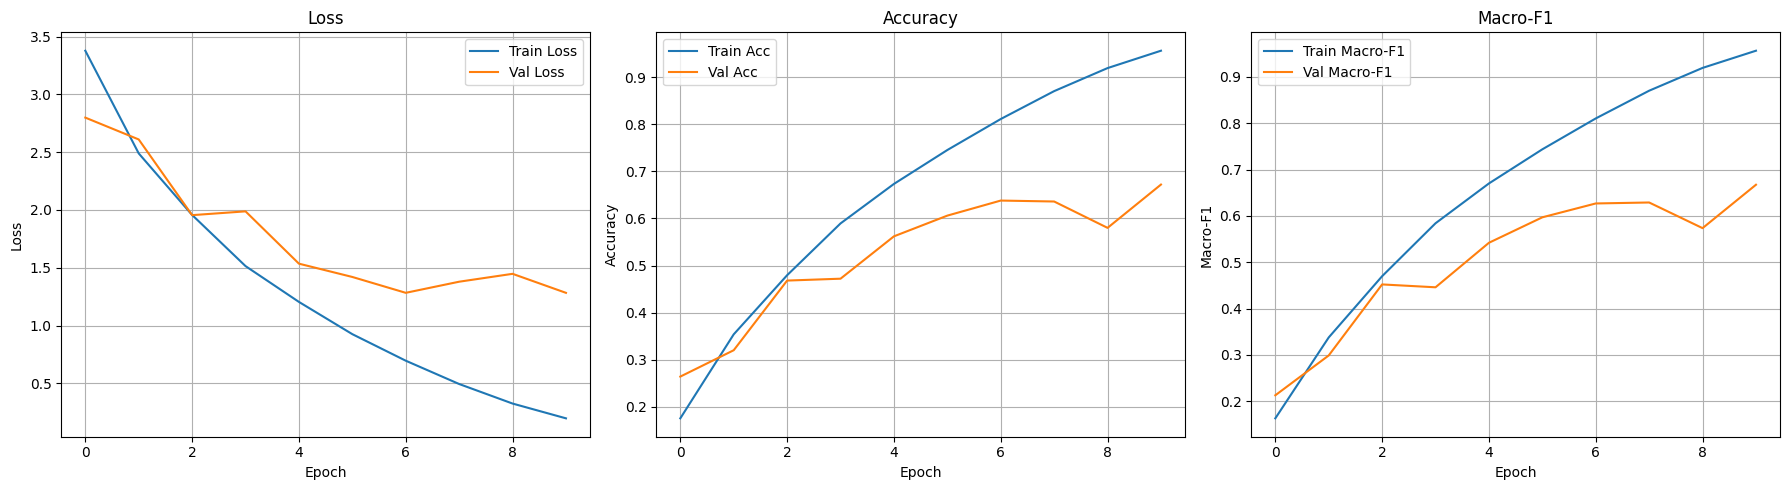

In [33]:
plot_history(history)

In [34]:
test_ds, test_loader = build_test_loader(cfg, device)

test_acc, test_f1, y_true, y_pred = evaluate(model, test_loader, device)

print("-" * 30)
print(f"Test Set Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Set Macro F1: {test_f1:.4f}")
print("-" * 30)

Test samples found: 500
Classes found: 100
------------------------------
Test Set Accuracy: 0.6680 (66.80%)
Test Set Macro F1: 0.6513
------------------------------


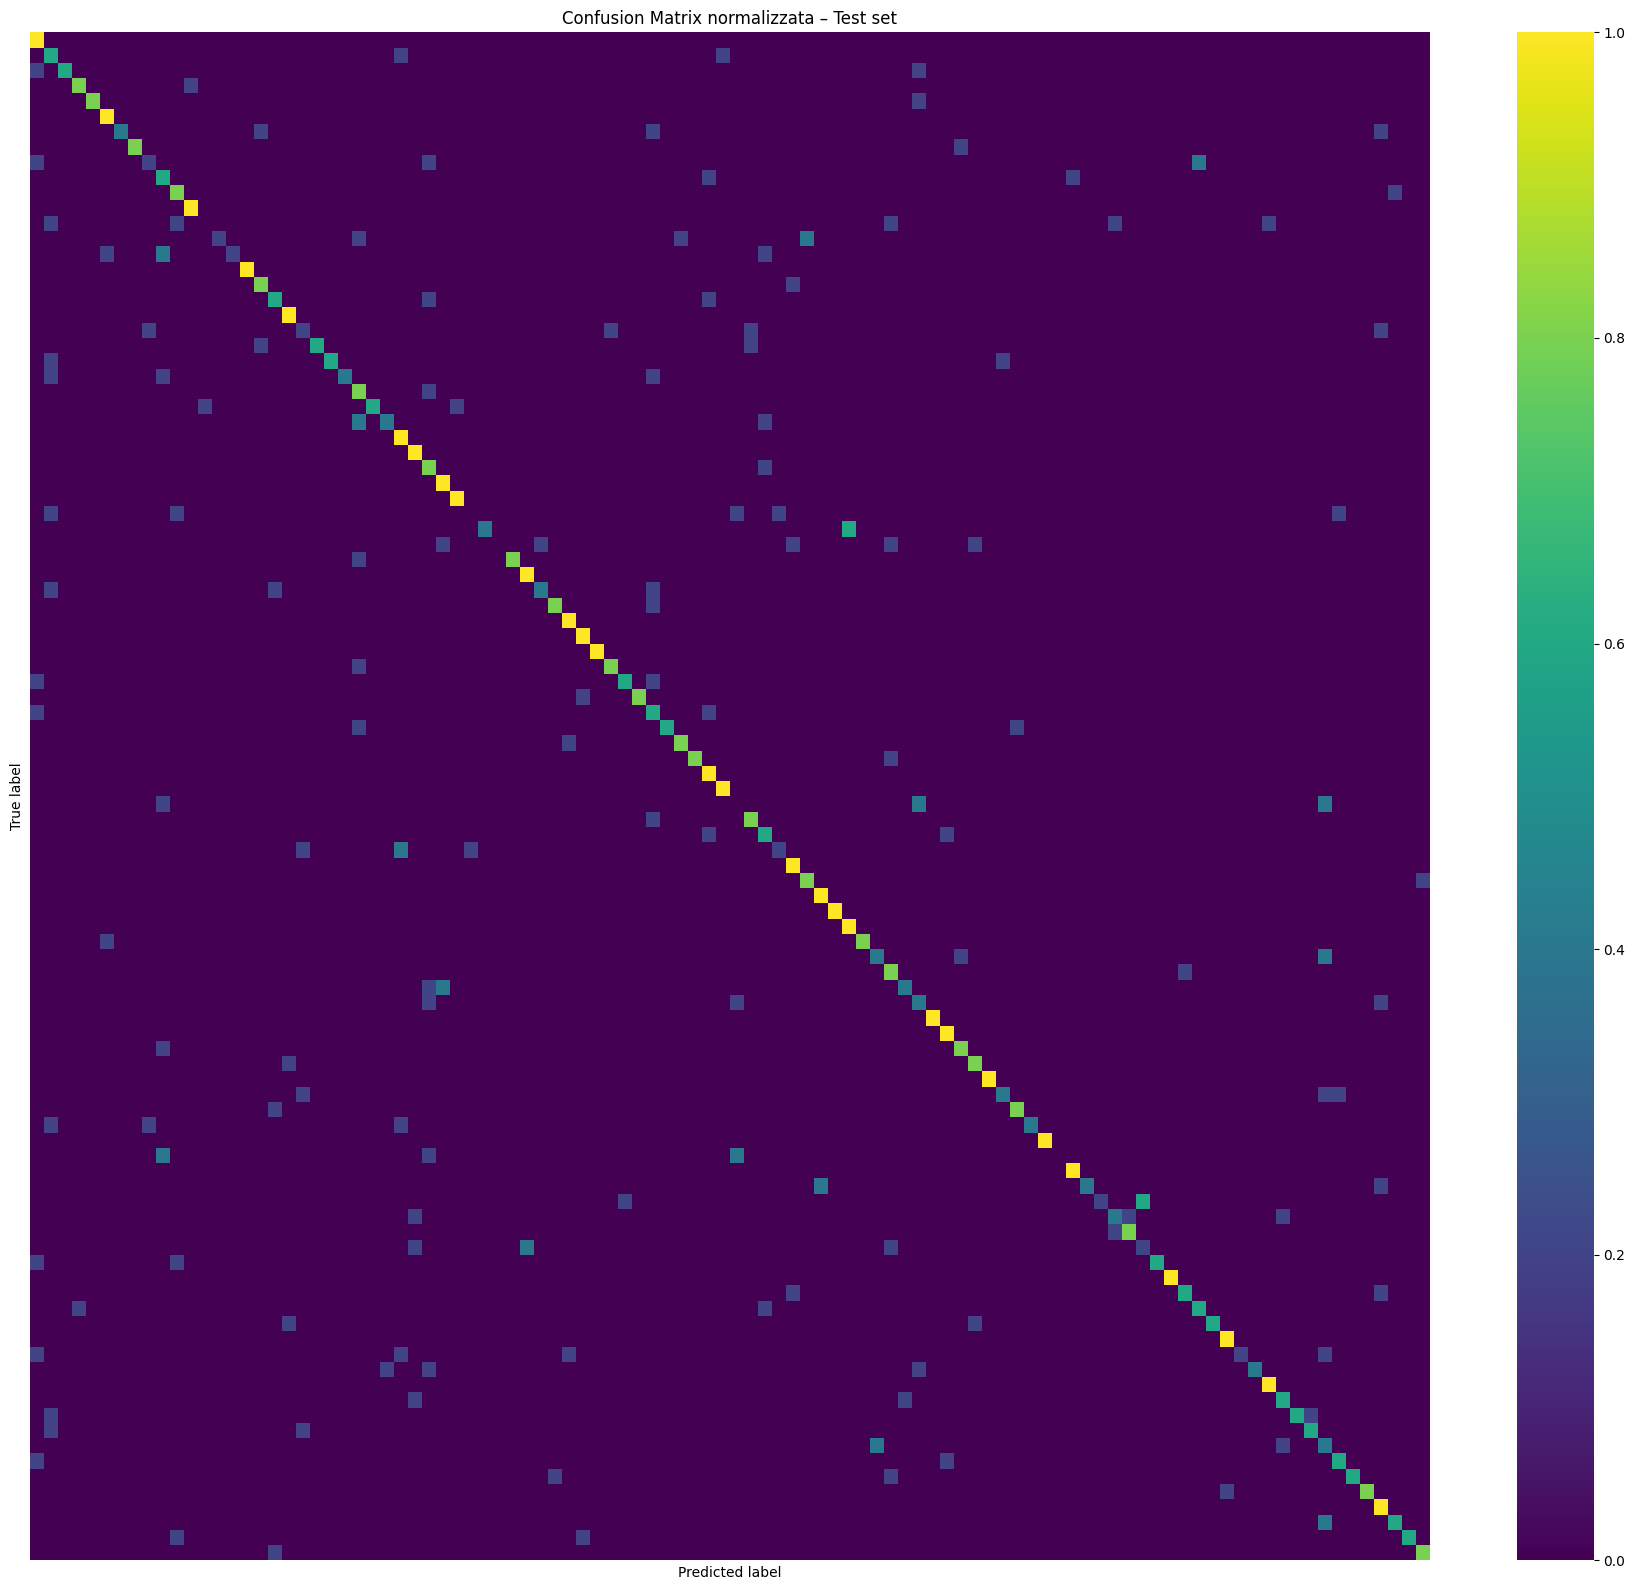

In [35]:
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, title="Confusion Matrix normalizzata – Test set")


In [36]:
print_top_confusions(cm, test_ds.classes, top_k=100)


Top 100 coppie più confuse:

formula 1 racing → nascar racing  | 3 errori
ski jumping → snow boarding  | 3 errori
basketball → sumo wrestling  | 2 errori
bobsled → luge  | 2 errori
bowling → baton twirling  | 2 errori
fencing → curling  | 2 errori
javelin → pole vault  | 2 errori
javelin → uneven bars  | 2 errori
lacrosse → field hockey  | 2 errori
parallel bar → uneven bars  | 2 errori
pole dancing → figure skating women  | 2 errori
shot put → baton twirling  | 2 errori
shot put → javelin  | 2 errori
sidecar racing → motorcycle racing  | 2 errori
snow boarding → giant slalom  | 2 errori
uneven bars → parallel bar  | 2 errori
wheelchair basketball → uneven bars  | 2 errori
ampute football → field hockey  | 1 errori
ampute football → jai alai  | 1 errori
archery → air hockey  | 1 errori
archery → pole vault  | 1 errori
arm wrestling → billiards  | 1 errori
axe throwing → pole vault  | 1 errori
barell racing → bull riding  | 1 errori
barell racing → horseshoe pitching  | 1 errori
barell